In [291]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

# Load the dataset
# data = pd.read_csv("Alltogether2.4v.csv")
data = pd.read_csv("Alltogether2.4v8Point.csv")
# data = pd.read_csv("Alltogether2.4v - copy.csv")
# data = pd.read_csv("Alltogether2.4vDivided.csv")

# Separate features and labels
X = data.drop(columns=["Material_Type"])
y = data["Material_Type"]


In [292]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets (Normal)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize features
# X_train_normalized = (X_train - X_train.min()) / (X_train.max() - X_train.min())
# X_test_normalized = (X_test - X_train.min()) / (X_train.max() - X_train.min())
X_train_normalized = ((X_train - 0) / (8410000 - 0))
X_test_normalized = ((X_test - 0) / (8410000 - 0))

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")
])

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 1.3966 - accuracy: 0.1933 - val_loss: 1.3294 - val_accuracy: 0.2667
Epoch 2/500
1/1 [==============================] - 0s 53ms/step - loss: 1.3851 - accuracy: 0.1933 - val_loss: 1.3242 - val_accuracy: 0.2667
Epoch 3/500
1/1 [==============================] - 0s 55ms/step - loss: 1.3751 - accuracy: 0.1933 - val_loss: 1.3203 - val_accuracy: 0.2667
Epoch 4/500
1/1 [==============================] - 0s 67ms/step - loss: 1.3670 - accuracy: 0.1933 - val_loss: 1.3167 - val_accuracy: 0.2667
Epoch 5/500
1/1 [==============================] - 0s 56ms/step - loss: 1.3596 - accuracy: 0.1933 - val_loss: 1.3135 - val_accuracy: 0.3000
Epoch 6/500
1/1 [==============================] - 0s 62ms/step - loss: 1.3529 - accuracy: 0.2689 - val_loss: 1.3109 - val_accuracy: 0.5667
Epoch 7/500
1/1 [==============================] - 0s 54ms/step - loss: 1.3469 - accuracy: 0.4370 - val_loss: 1.3087 - val_accuracy: 0.6000
Epoch 8/500
1/1 [=====

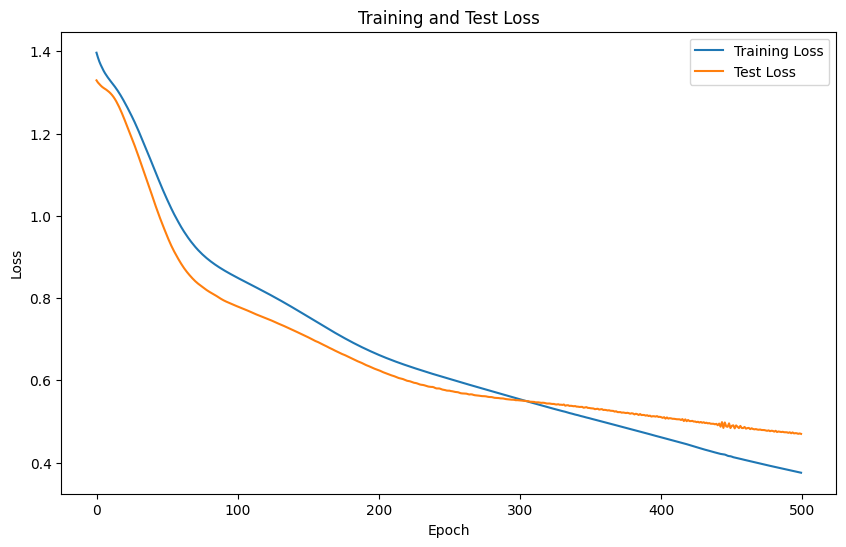

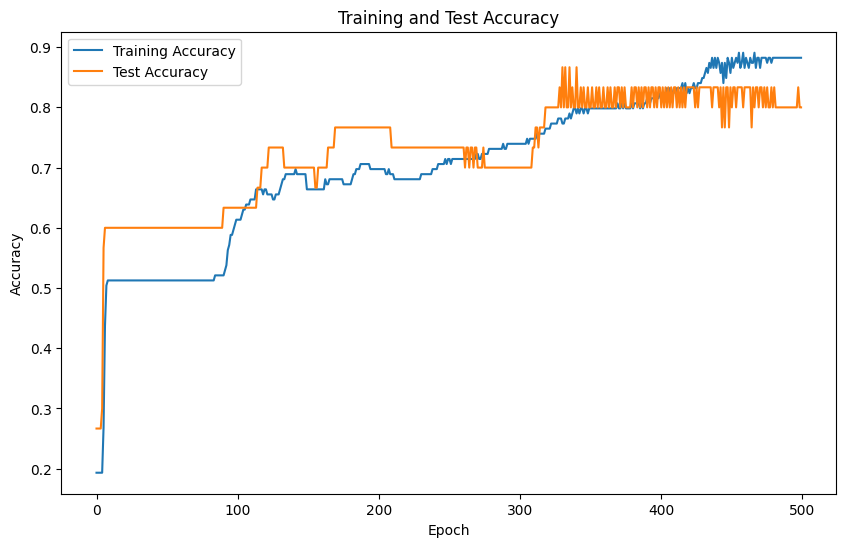

In [293]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Wait for 10 epochs without improvement
    min_delta=0.001,      # Minimum change required to consider an improvement
    verbose=1,            # Print messages about early stopping
    restore_best_weights=True
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_normalized, y_train, epochs=500, batch_size=128, validation_split=0.2, callbacks=[early_stopping])
# history = model.fit(X_train_normalized, y_train, epochs=200, batch_size=128, validation_split=0.2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test)

# Save the model
model.save("8_point_plastic_classifier_model.keras")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()



In [294]:
# Make predictions
predictions = model.predict(X_test_normalized)
predicted_labels = np.argmax(predictions, axis=1)
predicted_plastic_types = label_encoder.inverse_transform(predicted_labels)



# Convert predictions to percentage likelihood
percentage_likelihood = predictions.max(axis=1) * 100

# Display test accuracy and example predictions
print(f"Test Accuracy: {test_accuracy}")
for i in range(15):
    if y_test[i] == predicted_labels[i]:
        CorF = "Correct"
    else:
        CorF = "False"
    print(f"Sample {i+1}: {CorF} Predicted {predicted_plastic_types[i]} with {percentage_likelihood[i]:.2f}% likelihood")




total_params = model.count_params()
total_size_bytes = total_params * 4  # Each parameter is usually a 32-bit float
total_size_mb = total_size_bytes / (1024)  # Convert bytes to megabytes

print(f"Total size of the model: {total_size_mb:.2f} KB")


2/2 [==============================] - 0s 4ms/step
Test Accuracy: 0.8947368264198303
Sample 1: Correct Predicted ALU with 99.48% likelihood
Sample 2: Correct Predicted LDPE with 51.80% likelihood
Sample 3: Correct Predicted LDPE with 68.07% likelihood
Sample 4: Correct Predicted PP with 85.55% likelihood
Sample 5: Correct Predicted ALU with 100.00% likelihood
Sample 6: Correct Predicted HDPE with 96.77% likelihood
Sample 7: Correct Predicted LDPE with 66.84% likelihood
Sample 8: Correct Predicted ALU with 100.00% likelihood
Sample 9: Correct Predicted PP with 62.17% likelihood
Sample 10: Correct Predicted ALU with 99.96% likelihood
Sample 11: Correct Predicted ALU with 100.00% likelihood
Sample 12: Correct Predicted HDPE with 65.49% likelihood
Sample 13: Correct Predicted ALU with 99.96% likelihood
Sample 14: Correct Predicted HDPE with 74.00% likelihood
Sample 15: Correct Predicted LDPE with 93.55% likelihood
Total size of the model: 37.77 KB


In [295]:
# Make predictions
predictions = model.predict(X_test_normalized)

# Get the top 4 predictions for each sample
top_predictions = np.argsort(predictions, axis=1)[:, -4:]
top_labels = top_predictions[:, ::-1]

# print(predictions)

# Reshape the top_labels array to be 1D
top_labels_1d = top_labels.reshape(-1)

# Inverse transform the labels
top_plastic_types = label_encoder.inverse_transform(top_labels_1d)

# Reshape the top_plastic_types array back to 2D
top_plastic_types = top_plastic_types.reshape(top_labels.shape)

# Get the percentage likelihoods for the top 4 predictions
percentage_likelihoods = np.take_along_axis(predictions, top_predictions, axis=1) * 100

# Display test accuracy and example predictions
print(f"Test Accuracy: {test_accuracy}")
for i in range(len(predicted_labels)):
    num_predictions = min(4, len(np.unique(top_labels[i])))
    if y_test[i] == predicted_labels[i]:
        CorF = "Correct,"
    else:
        CorF = "False,"
    print(f"Sample {i+1}: {CorF} it was {label_encoder.classes_[y_test[i]]}")
    for j in range(num_predictions):
        print(f"  Prediction {j+1}: {top_plastic_types[i][j]} with {percentage_likelihoods[i][3-j]:.2f}% likelihood")

2/2 [==============================] - 0s 8ms/step
Test Accuracy: 0.8947368264198303
Sample 1: Correct, it was ALU
  Prediction 1: ALU with 99.48% likelihood
  Prediction 2: LDPE with 0.52% likelihood
  Prediction 3: HDPE with 0.00% likelihood
  Prediction 4: PP with 0.00% likelihood
Sample 2: Correct, it was LDPE
  Prediction 1: LDPE with 51.80% likelihood
  Prediction 2: PP with 27.95% likelihood
  Prediction 3: HDPE with 20.19% likelihood
  Prediction 4: ALU with 0.06% likelihood
Sample 3: Correct, it was LDPE
  Prediction 1: LDPE with 68.07% likelihood
  Prediction 2: PP with 17.25% likelihood
  Prediction 3: HDPE with 14.64% likelihood
  Prediction 4: ALU with 0.04% likelihood
Sample 4: Correct, it was PP
  Prediction 1: PP with 85.55% likelihood
  Prediction 2: HDPE with 9.67% likelihood
  Prediction 3: LDPE with 4.78% likelihood
  Prediction 4: ALU with 0.01% likelihood
Sample 5: Correct, it was ALU
  Prediction 1: ALU with 100.00% likelihood
  Prediction 2: LDPE with 0.00% like

In [296]:
# Get manual input from the user
manual_input = np.array([[400255,937687,1955595,3318033,3826709,2380639,1264331,783625,939273,1956581,3319213,5576989,2381183,1264955,782841]])  # Replace with your input values

# Normalize the manual input if needed
normalized_manual_input = ((manual_input - 0) / (8388608 - 0))

# Make predictions on manual input
predictions = model.predict(normalized_manual_input)
print(predictions)

# Get the top prediction
top_prediction = np.argmax(predictions)
print(top_prediction)

top_plastic_type = label_encoder.inverse_transform([top_prediction])[0]
print(top_plastic_type)
likelihood = predictions[0][top_prediction] * 100

# Display the prediction for manual input
print(f"Manual Input Prediction:")
print(f"  Prediction: {top_plastic_type} with {likelihood:.2f}% likelihood")

ValueError: in user code:

    File "c:\Users\kylej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\kylej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kylej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\kylej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\kylej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\kylej\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_47" is incompatible with the layer: expected shape=(None, 8), found shape=(None, 15)


In [ ]:
# Make predictions from manual
manual_input = np.array([[1047055,2403409,3929955,4807085,6261658,5048526,2421014,1641268,1309392,2610106,3863733,5212999,5402417,3628861,2006927
]])

# Calculate the column-wise min and max values from your original dataset
min_values = [74296, 1151721, 2379300, 2748695, 3681840, 1997402, 1742243, 942818, 392145, 795677, 1406647, 2482140, 2630495, 1748806, 1249297]
max_values = [1773075, 3755206, 7787954, 8401566, 8405071, 8401566, 7232265, 8185313, 2080604, 4455589, 8402979, 8405071, 8405071, 8403086, 6084492]

# Convert the lists to numpy arrays
min_values = np.array(min_values)
max_values = np.array(max_values)

# Normalize the manual input using the calculated min and max values
normalized_manual_input = (manual_input - min_values) / (max_values - min_values)
# normalized_manual_input = np.array([[0.85611,0.63202,0.53239,0.41068,0.59174,0.39869,0.44654,0.42188,0.8826042,0.67470967,0.34701898,0.42024683,0.34977269,0.16862726,0.1471771]])

print(normalized_manual_input)

predictions = model.predict(normalized_manual_input)
predicted_labels = np.argmax(predictions, axis=1)
predicted_plastic_types = label_encoder.inverse_transform(predicted_labels)

    
## Calculate the percentage likelihoods
percentage_likelihoods = predictions * 100

# Get the indices of the top 4 predicted classes based on percentage likelihoods
top_indices = np.argsort(percentage_likelihoods[0])[::-1][:4]

# Get the labels for the top predicted classes
top_labels = label_encoder.inverse_transform(top_indices)

# Get the predicted label
predicted_label = top_labels[0]

# Get the true label from the original data (replace with your true label)
true_label = 'ALU'  # Replace with the true label

# Calculate the accuracy
if predicted_label == true_label:
    accuracy = "Correct"
else:
    accuracy = "False"

# Print the prediction, label, and accuracy
print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")
print(f"Accuracy: {accuracy}")

# Print the percentages for each type
for label, likelihood in zip(top_labels, percentage_likelihoods[0][top_indices]):
    print(f"{label}: {likelihood:.2f}% likelihood")

# ... (rest of the code)

[[0.57262245 0.48077404 0.28669887 0.36413178 0.54619772 0.47642815
  0.12363721 0.09643776 0.54324505 0.49575755 0.35119631 0.46106548
  0.48002174 0.2825332  0.15669068]]
1/1 [==============================] - 0s 21ms/step
Predicted label: HDPE
True label: ALU
Accuracy: False
HDPE: 98.76% likelihood
PP: 1.12% likelihood
LDPE: 0.12% likelihood
ALU: 0.00% likelihood
